# Cooperative Co-Evolution Lab: Evolving Neural Controllers in a Maze

## Problem Statement

In this lab, you will implement and experiment with a **cooperative co-evolutionary algorithm** to evolve a neural network controller that navigates a robot through a **maze-like environment** toward a goal.

The robot is controlled by a neural network. The network is split into modules (e.g., input-to-hidden weights, hidden-to-output weights), each evolved by a **separate population**. Individuals from each subpopulation are combined to form a complete neural network for evaluation.

The environment is a 2D discrete grid world with **maze-like obstacles** generated such that a valid path to the goal always exists.

Your task is to evolve the controller so the robot reaches the goal in as few steps as possible, avoiding obstacles.

---

## Your Tasks

### 1. Experiment with Pairing Strategies

Currently, individuals from different subpopulations are evaluated by randomly pairing with collaborators from other populations.  
🔧 **Implement at least two alternative pairing strategies**, such as:

- **Best-so-far pairing**: Always pair individuals with the elite of the other population. 
- **Round-robin**: Evaluate each individual against multiple collaborators and average the result to determine fitness.
- **Fitness-proportionate sampling**: Choose partners with a probability based on fitness.

📝 Consider how different strategies affect both convergence and population diversity.

---

### 2. Extend the Network Architecture

Modify the code to include an **additional layer** in the neural network (e.g., two hidden layers instead of one).  
This will require:

- Adding a new set of weights (e.g., hidden1-to-hidden2),
- Creating a **third population** to evolve those weights,
- Updating the network construction and evaluation logic accordingly.

After implementation, reflect on how this change impacts performance and evolutionary dynamics.

In [15]:
import numpy as np
import random
import pygame
import sys
import copy
import matplotlib.pyplot as plt

In [16]:
# Define the grid environment
class GridEnvironment:
    def __init__(self, size=10, goal=(8, 8), max_steps=50, fixed_obstacles=None):
        self.size = size
        self.goal = np.array(goal)
        self.max_steps = max_steps
        self.fixed_obstacles = fixed_obstacles
        self.reset()

    def reset(self):
        self.position = np.array([0, 0])
        self.trajectory = [self.position.copy()]
        self.steps = 0
        if self.fixed_obstacles is not None:
            self.obstacles = self.fixed_obstacles
        else:
            self.obstacles = self.generate_maze_with_path()

    def generate_maze_with_path(self):
        # Simple DFS maze generator that guarantees a path from start to goal
        from collections import deque

        maze = np.ones((self.size, self.size), dtype=int)  # 1 = wall, 0 = free
        stack = [(0, 0)]
        visited = set()

        while stack:
            x, y = stack.pop()
            if (x, y) in visited:
                continue
            visited.add((x, y))
            maze[y, x] = 0

            neighbors = []
            for dx, dy in [(0, 2), (2, 0), (0, -2), (-2, 0)]:
                nx, ny = x + dx, y + dy
                if 0 <= nx < self.size and 0 <= ny < self.size and (nx, ny) not in visited:
                    neighbors.append((nx, ny))

            random.shuffle(neighbors)
            for nx, ny in neighbors:
                wx, wy = (x + nx) // 2, (y + ny) // 2
                maze[wy, wx] = 0
                stack.append((nx, ny))

        # Make sure start and goal are open
        maze[0, 0] = 0
        maze[self.goal[1], self.goal[0]] = 0

        obstacles = set((x, y) for y in range(self.size) for x in range(self.size) if maze[y, x] == 1)
        return obstacles

    def get_state(self):
        delta = self.goal - self.position
        return delta / np.linalg.norm(delta + 1e-8)

    def step(self, action):
        move = np.round(action).astype(int)
        new_pos = np.clip(self.position + move, 0, self.size - 1)
        if tuple(new_pos) not in self.obstacles:
            self.position = new_pos
        self.trajectory.append(self.position.copy())
        self.steps += 1
        done = np.array_equal(self.position, self.goal) or self.steps >= self.max_steps
        return self.get_state(), self.get_fitness(), done

    def get_fitness(self):
        dist = np.linalg.norm(self.goal - self.position)
        return -dist

    def render_pygame(self, screen, cell_size, clock, fps):
        for pos in self.trajectory:
            self._render_frame(screen, cell_size, pos)
            pygame.display.flip()
            clock.tick(fps)

    def _render_frame(self, screen, cell_size, current_pos):
        screen.fill((255, 255, 255))
        for y in range(self.size):
            for x in range(self.size):
                rect = pygame.Rect(x * cell_size, y * cell_size, cell_size, cell_size)
                pygame.draw.rect(screen, (200, 200, 200), rect, 1)

        for x, y in self.obstacles:
            pygame.draw.rect(screen, (100, 100, 100), (x * cell_size, y * cell_size, cell_size, cell_size))

        for pos in self.trajectory:
            pygame.draw.rect(screen, (100, 200, 255), (pos[0] * cell_size, pos[1] * cell_size, cell_size, cell_size))

        pygame.draw.rect(screen, (0, 255, 0), (self.goal[0] * cell_size, self.goal[1] * cell_size, cell_size, cell_size))
        pygame.draw.rect(screen, (255, 0, 0), (current_pos[0] * cell_size, current_pos[1] * cell_size, cell_size, cell_size))


In [17]:
# Simple neural network with fixed structure
class SimpleNN:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.w1 = np.zeros((input_size, hidden_size))
        self.w2 = np.zeros((hidden_size, output_size))

    def forward(self, x):
        h = np.tanh(x @ self.w1)
        out = np.tanh(h @ self.w2)
        return out


In [28]:
# Cooperative co-evolution framework
class CoopCoevolution:
    def __init__(self, input_size, hidden_size, output_size, pop_size=20, tournament_size=3):
        self.pop_size = pop_size
        self.tournament_size = tournament_size
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.pop_w1 = [np.random.randn(input_size * hidden_size) for _ in range(pop_size)]
        self.pop_w2 = [np.random.randn(hidden_size * output_size) for _ in range(pop_size)]
        self.fixed_obstacles = GridEnvironment().generate_maze_with_path()
        self.best_fitness_per_generation = []
        self.evaluations = 0

    def evaluate(self, w1_vec, w2_vec):
        env = GridEnvironment(fixed_obstacles=self.fixed_obstacles)
        nn = SimpleNN(self.input_size, self.hidden_size, self.output_size)
        nn.w1 = w1_vec.reshape(self.input_size, self.hidden_size)
        nn.w2 = w2_vec.reshape(self.hidden_size, self.output_size)

        env.reset()
        state = env.get_state()
        done = False
        while not done:
            action = nn.forward(state)
            state, _, done = env.step(action)
        
        self.evaluations +=1
        return env.get_fitness(), env

    def tournament_selection(self, population, fitnesses):
        winners = []
        for _ in range(self.pop_size):
            participants = random.sample(list(zip(population, fitnesses)), self.tournament_size)
            winner = max(participants, key=lambda x: x[1])[0]
            winners.append(winner)
        return winners

    def arithmetic_crossover(self, parent1, parent2):
        alpha = random.random()
        return alpha * parent1 + (1 - alpha) * parent2

    def mutate(self, individual, mutation_rate=0.1):
        return individual + mutation_rate * np.random.randn(*individual.shape)

    def plot_fitness(self):
        plt.figure(figsize=(8, 4))
        plt.plot(self.best_fitness_per_generation, marker='o')
        plt.xlabel("Generation")
        plt.ylabel("Best Fitness")
        plt.title("Fitness Over Generations")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def train(self, generations=200, cell_size=50, fps=10, render_interval=10):
        pygame.init()
        screen = pygame.display.set_mode((500, 500))
        pygame.display.set_caption("Grid Evolution")
        clock = pygame.time.Clock()
        best_fitness_found = -1000 # overall from all combinations
        
        for gen in range(generations):
            # Modify here
            # best_pair, best_fitness = self.random_paring_co_evolution()
            best_pair, best_fitness = self.k_random_pairing_co_evolution()
            
            if gen != 0 and gen % render_interval == 0:
                ## Confirm for simulation
                _, best_env = self.evaluate(best_pair[0], best_pair[1])
                best_env.render_pygame(screen, cell_size, clock, fps)
                
                # Check the best pair so far! This is an all vs all evaluation
                best_pair = max(((w1, w2) for w1 in self.pop_w1 for w2 in self.pop_w2),
                            key=lambda pair: self.evaluate(pair[0], pair[1])[0])
                best_fitness_found, best_env = self.evaluate(best_pair[0], best_pair[1])
            
            # check the pairing strategy elite with the All vs All elite
            if best_fitness_found > best_fitness:
                self.best_fitness_per_generation.append(best_fitness_found)
            else:
                self.best_fitness_per_generation.append(best_fitness)

            print(f"Generation {gen}: Best Pop Fitness = {best_fitness:.2f}, Best Overall Fitness = {max(self.best_fitness_per_generation)}")
            
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    pygame.quit()
                    sys.exit()
            
            if best_fitness == 0:
                print(f"Found a solution on generation {gen}: Best Fitness = {best_fitness:.2f} after {self.evaluations} evaluations")
                _, best_env = self.evaluate(best_pair[0], best_pair[1])
                best_env.render_pygame(screen, cell_size, clock, fps)
                break
        
        if best_fitness !=0:
            print(f"Best Found solution on generation {gen}: Best Fitness = {best_fitness:.2f} after {self.evaluations} evaluations")        
            _, best_env = self.evaluate(best_pair[0], best_pair[1])
            best_env.render_pygame(screen, cell_size, clock, fps)
        pygame.quit()
        self.plot_fitness()
    
    def select_and_generate_next(self, population, fitnesses):
        selected = self.tournament_selection(population, fitnesses)
        next_gen = []
        for _ in range(self.pop_size // 2):
            p1, p2 = random.sample(selected, 2)
            c1 = self.mutate(self.arithmetic_crossover(p1, p2))
            c2 = self.mutate(self.arithmetic_crossover(p2, p1))
            next_gen.extend([c1, c2])
        return next_gen
    
    ##### Random paring, copy and adapt the function to other strategies ####
    def random_paring_co_evolution(self):
        fitness_w1 = []
        fitness_w2 = []
        pairings = []
        
        # Evaluation of pop_w1
        for w1 in self.pop_w1:
            partner = random.choice(self.pop_w2) # choose randomly the partner
            fit, _ = self.evaluate(w1, partner)  # evaluate only one pairing
            fitness_w1.append(fit)
            pairings.append((w1, partner, fit))

        # Evaluation of pop_w2
        for w2 in self.pop_w2:
            partner = random.choice(self.pop_w1) # choose randomly the partner
            fit, _ = self.evaluate(partner, w2) # evaluate only one pairing
            fitness_w2.append(fit)
            pairings.append((partner, w2, fit))

        # check best solution
        best_w1, best_w2, best_fit = max(pairings, key=lambda t: t[2])
    
        # selection, variation operators, offspring
        self.pop_w1 = self.select_and_generate_next(self.pop_w1, fitness_w1)
        self.pop_w2 = self.select_and_generate_next(self.pop_w2, fitness_w2)
        
        # elitism pop_w1
        self.pop_w1[0] = best_w1.copy()
        
        # elitism pop_w2
        self.pop_w2[0] = best_w2.copy()
        
        return (best_w1.copy(), best_w2.copy()), best_fit
    
    def k_random_pairing_co_evolution(self, k=3):
        fitness_w1 = []
        fitness_w2 = []
        pairings = []

        # Evaluate population w1 with k random partners from pop_w2
        for w1 in self.pop_w1:
            sampled_partners = random.sample(self.pop_w2, min(k, len(self.pop_w2)))
            scores = [self.evaluate(w1, partner)[0] for partner in sampled_partners]
            avg_fit = np.mean(scores)
            fitness_w1.append(avg_fit)
            for partner, score in zip(sampled_partners, scores):
                pairings.append((w1, partner, score))

        # Evaluate population w2 with k random partners from pop_w1
        for w2 in self.pop_w2:
            sampled_partners = random.sample(self.pop_w1, min(k, len(self.pop_w1)))
            scores = [self.evaluate(partner, w2)[0] for partner in sampled_partners]
            avg_fit = np.mean(scores)
            fitness_w2.append(avg_fit)
            for partner, score in zip(sampled_partners, scores):
                pairings.append((partner, w2, score))

        # Get best pairing based on max individual fitness in evaluations
        best_w1, best_w2, best_fit = max(pairings, key=lambda t: t[2])

        # Evolve both populations
        self.pop_w1 = self.select_and_generate_next(self.pop_w1, fitness_w1)
        self.pop_w2 = self.select_and_generate_next(self.pop_w2, fitness_w2)

        # Elitism: keep best individual in both populations
        self.pop_w1[0] = best_w1.copy()
        self.pop_w2[0] = best_w2.copy()

        return (best_w1.copy(), best_w2.copy()), best_fit

    


Generation 0: Best Pop Fitness = -0.00, Best Overall Fitness = -0.0
Found a solution on generation 0: Best Fitness = -0.00 after 120 evaluations


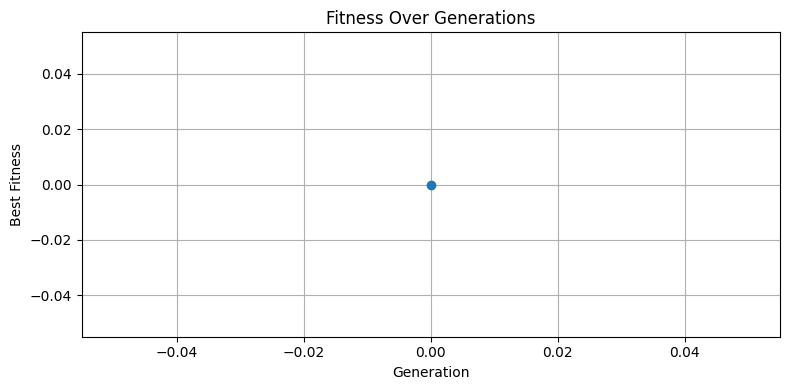

In [29]:
random.seed(2025) # 2025
np.random.seed(12345) # 12345

coop = CoopCoevolution(input_size=2, hidden_size=5, output_size=2)
coop.train(generations=10, render_interval=100)